# Super-Convergence Learning Rate Schedule  (TensorFlow Backend) 
In this example we will implement super-convergence learning rate (LR) schedule (https://arxiv.org/pdf/1708.07120.pdf) and test it on a CIFAR10 image classification task. Super-covergence is a phenomenon where neural networks can be trained an order of magnitude faster than with standard training methods. The paper proposes a LR schedule which incorporates two parts: a LR range test to find the appropriate LR range and a cyclical LR schedule that uses the obtained information. 

In [1]:
import tempfile

import numpy as np
import tensorflow as tf
from tensorflow.python.keras import layers

import fastestimator as fe
from fastestimator.backend import get_lr
from fastestimator.dataset.data.cifair10 import load_data
from fastestimator.op.numpyop.meta import Sometimes
from fastestimator.op.numpyop.multivariate import HorizontalFlip, PadIfNeeded, RandomCrop
from fastestimator.op.numpyop.univariate import CoarseDropout, Normalize, Onehot
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.trace import Trace
from fastestimator.trace.adapt import LRScheduler
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import Accuracy
from fastestimator.util.util import Suppressor
import matplotlib.pyplot as plt 

In [2]:
# Parameters
epochs=24
batch_size=128
lr_epochs=100
max_train_steps_per_epoch=None
save_dir=tempfile.mkdtemp()

## Network Architecture and Data Pipeline
We will use almost the same image classification configuration of the other Apphub example: [CIFAR10 Fast](../../image_classification/cifar10_fast/cifar10_fast.ipynb) including network architecture and data pipeline. The only difference is that we use SGD optimizer instead of Adam because author of the paper specially pointed out the incompatibility between Adam optimizer and super-convergence. 

In [3]:
def residual(x, num_channel):
    x = layers.Conv2D(num_channel, 3, padding='same')(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Conv2D(num_channel, 3, padding='same')(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    return x


def my_model():
    # prep layers
    inp = layers.Input(shape=(32, 32, 3))
    x = layers.Conv2D(64, 3, padding='same')(inp)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    # layer1
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.MaxPool2D()(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Add()([x, residual(x, 128)])
    # layer2
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.MaxPool2D()(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    # layer3
    x = layers.Conv2D(512, 3, padding='same')(x)
    x = layers.MaxPool2D()(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Add()([x, residual(x, 512)])
    # layers4
    x = layers.GlobalMaxPool2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(10)(x)
    x = layers.Activation('softmax', dtype='float32')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)

    return model

# prepare dataset
train_data, test_data = load_data()
pipeline = fe.Pipeline(
    train_data=train_data,
    eval_data=test_data,
    batch_size=batch_size,
    ops=[
        Normalize(inputs="x", outputs="x", mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616)),
        PadIfNeeded(min_height=40, min_width=40, image_in="x", image_out="x", mode="train"),
        RandomCrop(32, 32, image_in="x", image_out="x", mode="train"),
        Sometimes(HorizontalFlip(image_in="x", image_out="x", mode="train")),
        CoarseDropout(inputs="x", outputs="x", mode="train", max_holes=1),
        Onehot(inputs="y", outputs="y", mode="train", num_classes=10, label_smoothing=0.2)
    ])

# prepare network
model = fe.build(model_fn=my_model, optimizer_fn="sgd")
network = fe.Network(ops=[
    ModelOp(model=model, inputs="x", outputs="y_pred"),
    CrossEntropy(inputs=("y_pred", "y"), outputs="ce"),
    UpdateOp(model=model, loss_name="ce")
])

## LR Range Test
The preparation of the super-convergence schedule is to search the suitable LR range. The process is training the target network with a linearly increasing LR and observing the validation accuracy. Generally, the accuracy will keep increase until at some certain point when the LR get too high and start making training diverge. The very LR of that moment is the "maximum LR".

To run the test we need to implement the trace to record the maximum LR. After running the training with linear increaseing LR, we will get the maximum LR. 

<img src="./typical_lr.PNG" alt="drawing" width="400"/>
[The typical learning rate and metircs plot from https://arxiv.org/pdf/1708.07120.pdf]

In [4]:
def linear_increase(step, min_lr=0.0, max_lr=6.0, num_steps=1000):
    lr = step / num_steps * (max_lr - min_lr) + min_lr
    return lr

traces = [
    Accuracy(true_key="y", pred_key="y_pred"),
    LRScheduler(model=model, lr_fn=lambda step: linear_increase(step))
]

# prepare estimator
LR_range_test = fe.Estimator(pipeline=pipeline,
                             network=network,
                             epochs=lr_epochs,
                             traces=traces,
                             max_train_steps_per_epoch=10, 
                             log_steps=10)

# run the LR_range_test this 
print("Running LR range testing... It will take a while")
with Suppressor():
    summary = LR_range_test.fit("LR_range_test")

Running LR range testing... It will take a while


Let's plot the accuracy vs LR graph and see the maximum LR.

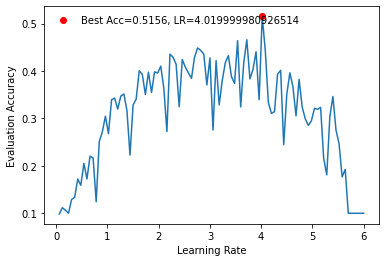

In [5]:
acc_steps = [step for step in summary.history["eval"]["accuracy"].keys()]    
acc_values = [acc for acc in summary.history["eval"]["accuracy"].values()]    
best_step, best_acc = max(summary.history["eval"]["accuracy"].items(), key=lambda k: k[1])   
lr_max = summary.history["train"]["model_lr"][best_step]    
lr_values = [summary.history["train"]["model_lr"][x] for x in acc_steps]    
assert len(lr_values) == len(acc_values)    
plt.plot(lr_values, acc_values)    
plt.plot(lr_max,
         best_acc,             
         'o',             
         color='r',             
         label="Best Acc={}, LR={}".format(best_acc, lr_max))    
plt.xlabel("Learning Rate")    
plt.ylabel("Evaluation Accuracy")    
plt.legend(loc='upper left', frameon=False)        

## Super-Convergence LR Schedule

Once we get the maximum LR, the minimum LR can be computed by dividing it by 40. Although this number is set to 4 in the paragraph of the original paper, it falls in range of [4, 40] in its experiment section. We empirically found 40 is the best value for this task.

The LR change has 3 phases:
1. increase LR from minimum LR to maximum LR at 0~45% of training process
2. decrase LR from maximum LR to minimum LR at 45%~90% of training process
3. decrase LR from minimum LR to 0 at 90%~100% of training process

<img src="./lr_schedule.PNG" alt="drawing" width="400"/>

In [6]:
lr_min = lr_max / 40
mid = int(epochs * 0.45 * len(train_data) / batch_size)
end = int(epochs * len(train_data) / batch_size)

def super_schedule(step):
    if step < mid:
        lr = step / mid * (lr_max - lr_min) + lr_min  # linear increase from lr_min to lr_max

    elif mid <= step < mid * 2:
        lr = lr_max - (step - mid) / mid * (lr_max - lr_min)  # linear decrease from lr_max to lr_min

    else:
        lr = max(lr_min - (step - 2 * mid) / (end - 2 * mid) * lr_min, 0)  # linear decrease from lr_min to 0

    return lr

Before we start the main training, the model needs to be reinitialized.  Therefore we re-instantiate the same network and plug the new LR scheduler in the estimator.

In [7]:
# reinitialize the model
model = fe.build(model_fn=my_model, optimizer_fn="sgd")
network = fe.Network(ops=[
    ModelOp(model=model, inputs="x", outputs="y_pred"),
    CrossEntropy(inputs=("y_pred", "y"), outputs="ce"),
    UpdateOp(model=model, loss_name="ce")
])

traces = [
    Accuracy(true_key="y", pred_key="y_pred"),
    BestModelSaver(model=model, save_dir=save_dir, metric="accuracy", save_best_mode="max"),
    LRScheduler(model=model, lr_fn=lambda step: super_schedule(step))
]

# prepare estimator 
main_train = fe.Estimator(pipeline=pipeline,
                          network=network,
                          epochs=epochs,
                          traces=traces,
                          max_train_steps_per_epoch=max_train_steps_per_epoch)

main_train.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; logging_interval: 100; num_device: 1;
FastEstimator-Train: step: 1; ce: 5.776663; model1_lr: 0.10142923;
FastEstimator-Train: step: 100; ce: 4.7230773; model1_lr: 0.19342318; steps/sec: 33.37;
FastEstimator-Train: step: 200; ce: 5.80881; model1_lr: 0.28634638; steps/sec: 33.49;
FastEstimator-Train: step: 300; ce: 2.3463163; model1_lr: 0.37926957; steps/sec: 33.87;
FastEstimator-Train: step: 391; epoch: 1; epoch_time: 12.47 sec;
FastEstimator-BestModelSaver: Saved model to /tmp/tmp9s08iyos/model1_best_accuracy.h5
FastEstimator

FastEstimator-Train: step: 5300; ce: 1.1538193; model1_lr: 3.0145712; steps/sec: 33.79;
FastEstimator-Train: step: 5400; ce: 1.1344184; model1_lr: 2.921648; steps/sec: 33.8;
FastEstimator-Train: step: 5474; epoch: 14; epoch_time: 11.67 sec;
FastEstimator-BestModelSaver: Saved model to /tmp/tmp9s08iyos/model1_best_accuracy.h5
FastEstimator-Eval: step: 5474; epoch: 14; accuracy: 0.8652; ce: 0.5354095; max_accuracy: 0.8652; since_best_accuracy: 0;
FastEstimator-Train: step: 5500; ce: 1.0998952; model1_lr: 2.8287246; steps/sec: 32.61;
FastEstimator-Train: step: 5600; ce: 1.141614; model1_lr: 2.7358015; steps/sec: 33.68;
FastEstimator-Train: step: 5700; ce: 1.1103913; model1_lr: 2.6428783; steps/sec: 33.8;
FastEstimator-Train: step: 5800; ce: 1.1439428; model1_lr: 2.5499551; steps/sec: 33.66;
FastEstimator-Train: step: 5865; epoch: 15; epoch_time: 11.72 sec;
FastEstimator-Eval: step: 5865; epoch: 15; accuracy: 0.8397; ce: 0.64034617; max_accuracy: 0.8652; since_best_accuracy: 1;
FastEstimat

## Result Discussion
The result of it might not be super impressive when comparing with original example [CIFAR10 Fast](../../image_classification/cifar10_fast/cifar10_fast.ipynb). But please be aware that the example has its own LR schedules which is specially tuned on that configuration (plus that scheduler is also cyclical LR schedule).